### week4. multiclass classification and Neural networks

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io 
import scipy.misc
import matplotlib.cm as cm
import random
import scipy.optimize
import itertools
from scipy.special import expit

### 1. multiclass classification
week3내용 연계

In [7]:
#down matlab data
datafile = 'ex3data1.mat'
mat = scipy.io.loadmat( datafile )
X, y = mat['X'], mat['y']
#Insert a column of 1's to X as usual
X = np.insert(X,0,1,axis=1)
print("'y' shape: %s. Unique elements in y: %s"%(mat['y'].shape,np.unique(mat['y'])))
print ("'X' shape: %s. X[0] shape: %s"%(X.shape,X[0].shape))
#X is 5000 images. Each image is a row. Each image has 400 pixels unrolled (20x20)
#y is a classification for each image. 1-10, where "10" is the handwritten "0"

'y' shape: (5000, 1). Unique elements in y: [ 1  2  3  4  5  6  7  8  9 10]
'X' shape: (5000, 401). X[0] shape: (401,)


In [10]:
#데이터 시각화
#단 데이터가 이미지 array로 나와있을 때 어떻게 시각화 하는지 참고하기

#1*400의 array를 생성하여 이미지를 생성하는 함수
def getDatumImg(row):
    width, height = 20,20
    square = row[1:].reshape(width, height)
    return square

#X에서 100개를 랜덤추출하여 20*20의 하나의 이미지 생성
def displayData(indices_to_display=None):
    width, height = 20,20
    nrows, ncols= 10, 10
    if not indices_to_display:
        indices_to_display=random.sample(range(X.shape[0]), nrows*ncols)
        
    big_picture = np.zeros((height*nrows,width*ncols))
    
    irow, icol = 0, 0
    for idx in indices_to_display:
        if icol == ncols:
            irow += 1
            icol  = 0
        iimg = getDatumImg(X[idx])
        big_picture[irow*height:irow*height+iimg.shape[0],icol*width:icol*width+iimg.shape[1]] = iimg
        icol += 1
    fig = plt.figure(figsize=(6,6))
    img = scipy.misc.toimage( big_picture )
    plt.imshow(img,cmap = cm.Greys_r)

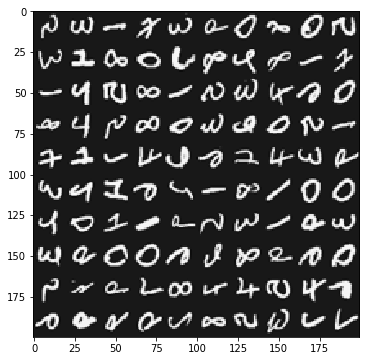

In [14]:
import warnings
warnings.filterwarnings('ignore')
displayData()

In [38]:
#vectorizing logistic regression

#logit함수에 h(x)를 적용한 함수
def h(mytheta, myX):
    return expit(np.dot(myX, mytheta))

#logistic함수의 costfunction
#A more simply written cost function than last week, inspired by subokita:
def computeCost(mytheta,myX,myy,mylambda = 0.):
    m = myX.shape[0] #5000
    myh = h(mytheta,myX) #shape: (5000,1)
    term1 = np.log( myh ).dot( -myy.T ) #shape: (5000,5000)
    term2 = np.log( 1.0 - myh ).dot( 1 - myy.T ) #shape: (5000,5000)
    left_hand = (term1 - term2) / m #shape: (5000,5000)
    right_hand = mytheta.T.dot( mytheta ) * mylambda / (2*m) #shape: (1,1)
    return left_hand + right_hand #shape: (5000,5000)

One-vs-all classification

In [39]:
#위의 computeCost를 이용하여 gradient descent를 적용
def costGradient(mytheta, myX, myy, mylambda=0.):
    m=myX.shape[0]
    #x곱하기 전의 derivitive term
    beta = h(mytheta,myX)-myy.T
    #regularization
    regterm = mytheta[1:]*(mylambda/m)
    grad = (1./m)*np.dot(myX.T,beta)
    grad[1:] = grad[1:] + regterm
    return grad

In [40]:
#costGradient적용결과를 이용하여 Octave의 내장함수를 이용한 최적theta
from scipy import optimize

def optimizeTheta(mytheta,myX,myy,mylambda=0.):
    result = optimize.fmin_cg(computeCost, fprime=costGradient, x0=mytheta, \
                              args=(myX, myy, mylambda), maxiter=50, disp=False,\
                              full_output=True)
    return result[0], result[1]

In [41]:
#실제 min(cost)을 가지는 theta를 구한다. 
def buildTheta():
    mylambda = 0.
    initial_theta = np.zeros((X.shape[1],1)).reshape(-1)
    Theta = np.zeros((10,X.shape[1]))
    for i in range(10):
        iclass = i if i else 10 #class "10" corresponds to handwritten zero
        print ("Optimizing for handwritten number %d..."%i)
        logic_Y = np.array([1 if x == iclass else 0 for x in y])#.reshape((X.shape[0],1))
        itheta, imincost = optimizeTheta(initial_theta,X,logic_Y,mylambda)
        Theta[i,:] = itheta
    print ("Done!")
    return Theta

Theta = buildTheta()

Optimizing for handwritten number 0...
Optimizing for handwritten number 1...
Optimizing for handwritten number 2...
Optimizing for handwritten number 3...
Optimizing for handwritten number 4...
Optimizing for handwritten number 5...
Optimizing for handwritten number 6...
Optimizing for handwritten number 7...
Optimizing for handwritten number 8...
Optimizing for handwritten number 9...
Done!


In [42]:
#handwritten image에 대해 One-vs-all로 multicategory계산
def predictOneVsAll(myTheta, myrow):
    classes=[10]+range(1,10)
    hypots=[0]*len(classes)
    
    #결과중 max를 predict
    for i in range(len(classes)):
        hypots[i]=h(myTheta[i],myrow)
    return classes[np.argmax(np.array(hypots))]

```python
#정확도
n_correct, n_total = 0., 0.
incorrect_indices = []
for irow in range(X.shape[0]):
    n_total += 1
    if predictOneVsAll(Theta,X[irow]) == y[irow]: 
        n_correct += 1
    else: incorrect_indices.append(irow)
print("Training set accuracy: %0.1f%%"%(100*(n_correct/n_total)))
```

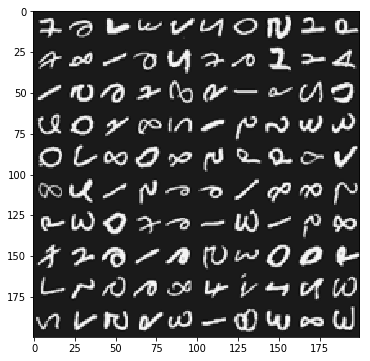

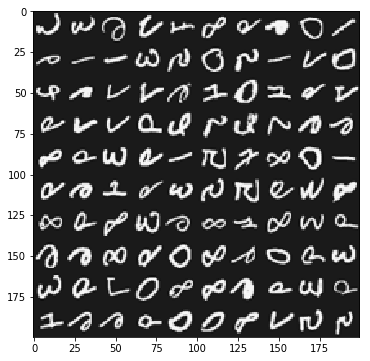

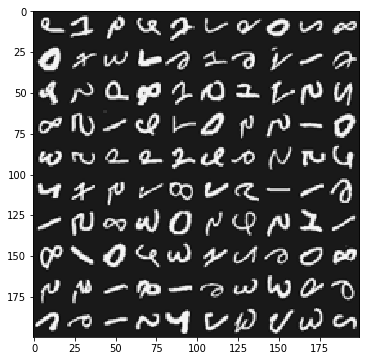

In [44]:
displayData(incorrect_indices[:100])
displayData(incorrect_indices[100:200])
displayData(incorrect_indices[200:300])

### 2. Neural Networks

In [46]:
#datafile확인
datafile = 'ex3weights.mat'
mat = scipy.io.loadmat( datafile )
Theta1, Theta2 = mat['Theta1'], mat['Theta2']

In [47]:
print("theta has shape:",Theta1.shape)
print("theta2 has shape:", Theta2.shape)

theta has shape: (25, 401)
theta2 has shape: (10, 26)


**Feedforward Propagation** <br>
앞에있는 layer에 weight를 더하여 만드는 식의 형태이다. 이는 neural network에서 주로 쓰이는 방식이다. . 

In [60]:
#theta값이 주어졌을 때, 계산하는 방식을 나타낸다. 
def propagationFoward(row, Thetas):
    features = row
    for i in range(len(Thetas)):
        Theta = Thetas[i]
        z = Theta.dot(features)
        a = expit(z)
        if i == len(Thetas)-1:
            return a
        a = np.insert(a,0,1) #Add the bias unit
        features = a

In [79]:
#predict NN
def predictNN(row, Thetas):
    classes = list(range(1,10))+[10]
    output = propagationFoward(row,Thetas)
    return classes[np.argmax(np.array(output))]

In [80]:
list(range(1,10))+[10]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [83]:
myThetas = [ Theta1, Theta2 ]
n_correct, n_total = 0., 0.
incorrect_indices = []


#잘못예측한 값에 대한 확인 및 정확도 확인
for irow in range(X.shape[0]):
    n_total += 1
    if predictNN(X[irow],myThetas) == int(y[irow]): #맞는 예측이었는지를 벡터로 확인 (맞는 경우 확인)
        n_correct += 1
    else: incorrect_indices.append(irow) #incorrect_indices값은 맞지 않게 예측한 값을 저장한 리스트를 의미한다.  

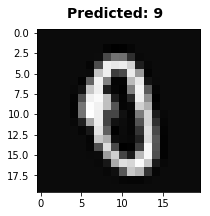

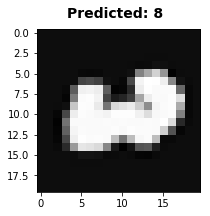

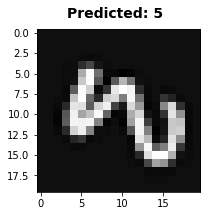

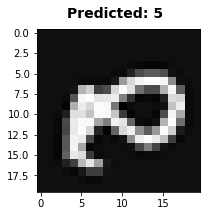

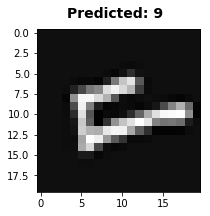

In [82]:
#잘못예측한 경우, 어떻게 잘못 예측한 건지 확인
for x in range(5):
    i = random.choice(incorrect_indices)
    fig = plt.figure(figsize=(3,3))
    img = scipy.misc.toimage( getDatumImg(X[i]) )
    plt.imshow(img,cmap = cm.Greys_r)
    predicted_val = predictNN(X[i],myThetas)
    predicted_val = 0 if predicted_val == 10 else predicted_val
    fig.suptitle('Predicted: %d'%predicted_val, fontsize=14, fontweight='bold')